<a href="https://colab.research.google.com/github/ashimdahal/Chicken-Recipe-Generator/blob/main/chicken.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import urllib.request

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!ls '/content/gdrive'

MyDrive


In [ ]:
text = open('/content/gdrive/MyDrive/chicken.txt').read()
dataset_orig = text.split('\n')
dataset_orig = [i.lower().replace('.','').replace(',','') for i in dataset_orig]


In [ ]:
np.array(dataset_orig).shape

(150,)

In [ ]:
url = 'http://vectors.nlpl.eu/repository/20/18.zip'

In [ ]:

with urllib.request.urlopen(url) as f:
    open('text.zip',mode='wb').write(f.read())
  

In [ ]:
import zipfile
with zipfile.ZipFile("/content/text.zip","r") as zip_ref:
    zip_ref.extractall("targetdir")
   

In [ ]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [ ]:
embedding = load_vectors('/content/targetdir/model.txt')

In [ ]:
def sen_to_list(sentence):
    return sentence.split(' ')

In [ ]:
largest_recipe = len(max(dataset_orig,key=len))

In [ ]:
embedding['serves'] = embedding['serve']

In [ ]:
def get_embedding_for_words(word,embedding):
    sentence_in_vec = []
    
    if word in embedding.keys():
        sentence_in_vec.append(np.array(embedding[word]))
    else:
        sentence_in_vec.append(np.zeros(300))
    
    return np.array(sentence_in_vec)


In [ ]:
char_to_idx ={}
for id,key in enumerate(embedding.keys()):
    char_to_idx[key] = id 


In [ ]:
char_to_idx['chicken']

5240

In [ ]:
def word_to_id(word):
    out =[]
    if type(word) == type([]):
        word = np.array(word).reshape(-1)
        for w in word:
            if w in char_to_idx.keys():
                out.append(char_to_idx[w])
            else:
                out.append(len(char_to_idx.keys()))
    else:
        if word in char_to_idx.keys():
            out.append(char_to_idx[word])
        else:
            out.append(len(char_to_idx.keys()))
    out = np.array(out)
    out = out[:,np.newaxis]
    return out


In [ ]:
def idx_to_char(idx):
    if idx < len(embedding.keys()):
        return list(embedding.keys())[idx]
    else:
        return '<unk>'


In [ ]:
def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))

def text_from_indices(seq):
    output=[]
    
    for i in seq:
        if i< len(embedding.keys()):
            output.append(list(embedding.keys())[int(i)])
        else:
            output.append('<unk>')
    return listToString(output)

In [ ]:
idx_to_char(9417)

'satisfy'

In [ ]:
def split_inp_seq(seq):
    return seq[:-1],seq[1:]

In [ ]:
from tensorflow.keras.layers import Dense,LSTM,Embedding, Input,Dropout, Activation,Reshape,GRU
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

Vocab_size = np.array(list(embedding.keys())).shape[0] + 1
gru = tf.keras.layers.GRU(1512,
                                   return_sequences=True,
                                   return_state=True)


densor = Dense(Vocab_size)


In [ ]:
def make_dataset(X,char_to_idx,embedding,max_len):
    m = X.shape[0]                                   # number of training examples
    
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words= X[i].split()
        
   
        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in embedding.keys():
                X_indices.append(char_to_idx[w])
            
    # X_indices = [i for i in X_indices.ravel() if i!=0]
    
    return X_indices

In [ ]:
X = make_dataset(np.array(dataset_orig),char_to_idx,embedding,largest_recipe)
# np.array(padded_dataset.shape

In [ ]:
X =tf.Variable(X)
X = tf.convert_to_tensor(X)
X

<tf.Tensor: shape=(6731,), dtype=int32, numpy=array([ 15703,   5240, 218643, ...,  32435,   5810,  21288], dtype=int32)>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(X)

In [ ]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

In [ ]:
len(embedding.keys())

291186

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
    print(text_from_indices(seq))

boil chicken and cool remove meat set aside in a large bowl add cream of chicken soups 1 1/2 cans of broth and 1 1/2 cans of milk stir altogether and add stuffing and chicken mix well together put 13 9 2-inch and round pan bake 35 40 minutes pan use may put pats of butter top place chicken in large casserole dish mix soup and milk pour chicken sprinkle parsley bake 1 1/2 hours serves 4 6 enjoy in 13 9-inch pan combine soups sour cream broth onion mushrooms and spices arrange chicken top of sauce bake uncovered 1 hour


In [ ]:
dataset = sequences.map(split_inp_seq)

In [ ]:
# Batch size
BATCH_SIZE = 32

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 1000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((32, 100), (32, 100)), types: (tf.int32, tf.int32)>

In [ ]:
def make_emb_layer(embedding):
    vocab_size = np.array(list(embedding.keys())).shape[0] + 1   
    embedding_dim = np.array(embedding[list(embedding.keys())[0]]).shape[0]

    emb_matrix = np.zeros((vocab_size,embedding_dim))

    for idx,word in enumerate(list(embedding.keys())):
        emb_matrix[idx,:] = embedding[word]

    embedding_layer = Embedding(vocab_size,output_dim=embedding_dim,trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer


In [ ]:
class InitialEasyModel(tf.keras.Model):
    def __init__(self,emb_layer,gru,densor):
        super().__init__(self)
        self.emb_layer = emb_layer
        self.gru = gru
        self.densor = densor
        self.drop = Dropout(0.4)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.emb_layer(x,training=training)

        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
   
        x = self.drop(x)
        x = self.densor(x, training=training)
       
        
        if return_state:
            return x, states
        else:
            return x



In [ ]:
emb_layer = make_emb_layer(embedding)
model = InitialEasyModel(emb_layer,gru,densor)
input_shape =(16,100)
model.build(input_shape=input_shape)

In [ ]:
opt = Adam()
Loss =tf.losses.SparseCategoricalCrossentropy(from_logits=True)
EPOCHS = 20

In [ ]:
model.compile(optimizer=opt,loss=Loss)

In [ ]:
model.summary()

Model: "initial_easy_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  87356100  
_________________________________________________________________
gru (GRU)                    multiple                  8228304   
_________________________________________________________________
dense (Dense)                multiple                  440565931 
_________________________________________________________________
dropout (Dropout)            multiple                  0         
Total params: 536,150,335
Trainable params: 448,794,235
Non-trainable params: 87,356,100
_________________________________________________________________


In [ ]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/20


In [ ]:
history.params

{'epochs': 20, 'steps': 2, 'verbose': 1}

In [ ]:
history.history.keys()

dict_keys(['loss'])

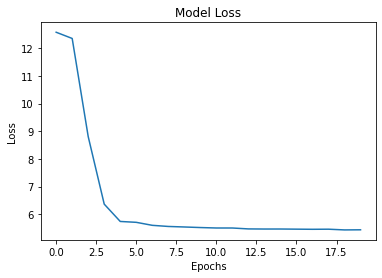

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
chicken = np.array([120,560])
chicken = chicken[:,np.newaxis]
chicken

array([[120],
       [560]])

In [ ]:
class oneWord(tf.keras.Model):
    def __init__(self,word_to_vec,text_from_id,model,vocab = 291187):
        super().__init__(self)
      
        self.vec = word_to_vec
        self.text = text_from_id
        self.model = model

        skip_id = self.vec('<unk>')
        sparse_mask = tf.SparseTensor(
       
        values=[-float('inf')]*len(skip_id),
        indices=skip_id,
       
        dense_shape=[vocab])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    # @tf.function 
    def generate(self,inpword,states=None):
        input = self.vec(inpword)

        pred,states=self.model(input,states=states,return_state=True,training=False)
        
        pred = pred[:,-1,:]
        pred = pred + self.prediction_mask
        
        pred = tf.random.categorical(pred,num_samples=1)

        pred = tf.squeeze(pred,axis=-1)
        pred = self.text(pred)
        # print(pred)
        return pred,states

In [ ]:
generator = oneWord(word_to_id,text_from_indices,model)

In [ ]:
next_w= 'put'
out = [next_w]
state=None
for i in range(50):
    next_w,state = generator.generate(next_w,state)
    out.append(next_w)
listToString(out)

'put Pappus cheeses adding flour full shredded smooth apple salt dish 5 olive seasonings place and juice sliced combine mix lemon place sauce thicken stir heat saute 4 1 45 onion pieces oil 45 medium-low cook two simmer of simmer and chicken evenly inches in pull breast margarine method 1/2 salt'

In [ ]:
del model
del dataset
del X
del generator

In [ ]:
def make_pad_dataset(max_inp,X,word_to_idx):
    m = X.shape[0]
    X_indices = np.full((m,max_inp),fill_value=len(word_to_idx) ,dtype=np.int)
    for i in range(m):
        sentence = X[i].split()
        j = 0
        for w in sentence:
            if j < max_inp:
                X_indices[i,j] = int(word_to_idx[w]) if w in word_to_idx.keys() else len(word_to_idx)
                j+=1
    return X_indices
X = make_pad_dataset(420,np.array(dataset_orig),char_to_idx)+ 1e-5

In [ ]:
y = X.copy()
y = np.roll(y,-1,1)
y[0][1],X[0][2]

(218643.00001, 218643.00001)

In [ ]:

X = tf.constant(X)
X = tf.convert_to_tensor(X)
y= tf.constant(y)
y=tf.convert_to_tensor(y)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X,y))
dataset

<TensorSliceDataset shapes: ((420,), (420,)), types: (tf.float64, tf.float64)>

In [ ]:
# dataset = dataset.map(split_inp_seq)

In [ ]:
BATCH_SIZE = 4

BUFFER_SIZE = 1000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
dataset

<PrefetchDataset shapes: ((4, 420), (4, 420)), types: (tf.float64, tf.float64)>

In [ ]:
class ModelWithPadding(tf.keras.Model):
    def __init__(self, num_gru,vocab_size,emb_layer):
        super().__init__(self)
        self.gru = GRU(num_gru,return_sequences=True,return_state=True)
        self.emb = emb_layer
        self.dense = Dense(vocab_size)
        self.drop = Dropout(0.4)

    def call(self,input,states=None,return_state=False,training=False):
        X = input
        X  = self.emb(X)
        if states is None:
            states = self.gru.get_initial_state(X)
        X,states = self.gru(X,training=training,initial_state=states)
        x = self.drop(X)
        x = self.dense(x)

        if return_state:
            return x,states
        else:
            return x
    


In [ ]:
model_with_padding = ModelWithPadding(516,Vocab_size,emb_layer)
input_shape = (4,420)
model_with_padding.build(input_shape= input_shape)

In [ ]:
model_with_padding.summary()

Model: "model_with_padding_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_17 (GRU)                 multiple                  1266264   
_________________________________________________________________
embedding (Embedding)        multiple                  87356100  
_________________________________________________________________
dense_17 (Dense)             multiple                  150543679 
_________________________________________________________________
dropout_17 (Dropout)         multiple                  0         
Total params: 239,166,043
Trainable params: 151,809,943
Non-trainable params: 87,356,100
_________________________________________________________________


In [ ]:
opt = Adam(clipvalue=0.5)
Loss =tf.losses.SparseCategoricalCrossentropy(from_logits=True)
EPOCHS = 15
model_with_padding.compile(optimizer=opt,loss=Loss)

In [ ]:
history = model_with_padding.fit(dataset,epochs=EPOCHS)

Epoch 1/15
37/37 [==============================] - 25s 648ms/step - loss: 5.0429
Epoch 2/15
37/37 [==============================] - 25s 671ms/step - loss: 1.0217
Epoch 3/15
37/37 [==============================] - 25s 685ms/step - loss: 0.9235
Epoch 4/15
37/37 [==============================] - 26s 690ms/step - loss: 0.8253
Epoch 5/15
37/37 [==============================] - 26s 703ms/step - loss: 0.7683
Epoch 6/15
37/37 [==============================] - 27s 717ms/step - loss: 0.7488
Epoch 7/15
37/37 [==============================] - 27s 733ms/step - loss: 0.7158
Epoch 8/15
37/37 [==============================] - 27s 743ms/step - loss: 0.7129
Epoch 9/15
37/37 [==============================] - 27s 741ms/step - loss: 0.7043
Epoch 10/15
37/37 [==============================] - 27s 732ms/step - loss: 0.6967
Epoch 11/15
37/37 [==============================] - 28s 747ms/step - loss: 0.6908
Epoch 12/15
37/37 [==============================] - 27s 741ms/step - loss: 0.6937
Epoch 13/15
3

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
generator = oneWord(word_to_id,text_from_indices,model_with_padding)

In [ ]:
w = 'boil'
state = None
out =[w]
for i in range(120):
    w,state = generator.generate(w,states=state)
    out.append(w)
listToString(out)

'boil place chili cutlets chicken cover resealable minutes the skillet uncovered milk turn cornflakes and in and the pan in pieces skillet the milk add large add simmer beginning brown heat the saute tomatoes add chicken and crust pour brown corn half hollandaise golden bread sauce the coconut and add nacho 1 in cook onion avocado chicken garlic method beef chicken sprigs sauce and large brushing bacon stirring pan add gently of powder pan stir curry simmer side coconut plate stir medium-high bubbles and powder serve in pan of salt sauce in juice baking broth stir the heat 1 curry dabs together 1 water a chips golden chicken pan turn chicken and pieces and pieces smooth wing bring and and brown'

In [ ]:
dataset = [i.lower().replace('.','') for i in text.split()]
vocab =list(set(dataset))
vocab.append('<unk>')
# vocab


In [ ]:
char_to_id ={}
for i,word in enumerate(vocab):
    char_to_id[word] = float(i)
char_to_id['chicken']

def word_to_vec(word):
    out =[]
    if type(word) == type([]):
        word = np.array(word).reshape(-1)
        for w in word:
            if w in char_to_id.keys():
                out.append(char_to_id[w])
            else:
                out.append(len(char_to_id.keys()))
    else:
        if word in char_to_id.keys():
            out.append(char_to_id[word])
        else:
            out.append(len(char_to_id.keys()))
    out = np.array(out)
    out = out[:,np.newaxis]
    return out

def text_from_id(seq):
    output=[]
    
    for i in seq:
        if i< len(char_to_id.keys()):
            output.append(list(char_to_id.keys())[int(i)])
        else:
            output.append('<unk>')
    return listToString(output)

In [ ]:
def ids_to_char(ids):
    out = []
    for i in ids:
        out.append(vocab[i]) if i < len(vocab) else out.append('<unk>')

    return out

In [ ]:
def make_emb_data(max_inp,word_to_idx,X):
    m = X.shape[0]
    X_indices = np.full((m,max_inp),fill_value=len(word_to_idx))
    for i in range(m):
        sentence = X[i].split()
        j = 0
        for w in sentence:
            if j < max_inp:
                X_indices[i,j] = int(word_to_idx[w]) if w in word_to_idx.keys() else len(word_to_idx)
                j+=1
    return X_indices

X = make_emb_data(largest_recipe,char_to_id,np.array(dataset_orig))
y = X.copy()
y = np.roll(y,-1,1)

In [ ]:
X.shape

(150, 730)

In [ ]:
X = tf.constant(X)
X = tf.convert_to_tensor(X)
y= tf.constant(y)
y=tf.convert_to_tensor(y)
y,X

(<tf.Tensor: shape=(150, 730), dtype=int64, numpy=
 array([[1192,   22,  193, ..., 1212, 1212,  759],
        [1192,  139, 1193, ..., 1212, 1212,  571],
        [ 931,  761, 1162, ..., 1212, 1212,  139],
        ...,
        [ 754, 1192,    1, ..., 1212, 1212, 1067],
        [1120,   22, 1140, ..., 1212, 1212,  297],
        [1120, 1140,   22, ..., 1212, 1212,  297]])>,
 <tf.Tensor: shape=(150, 730), dtype=int64, numpy=
 array([[ 759, 1192,   22, ..., 1212, 1212, 1212],
        [ 571, 1192,  139, ..., 1212, 1212, 1212],
        [ 139,  931,  761, ..., 1212, 1212, 1212],
        ...,
        [1067,  754, 1192, ..., 1212, 1212, 1212],
        [ 297, 1120,   22, ..., 1212, 1212, 1212],
        [ 297, 1120, 1140, ..., 1212, 1212, 1212]])>)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X,y))

In [ ]:
BATCH_SIZE = 32

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
dataset

<PrefetchDataset shapes: ((32, 730), (32, 730)), types: (tf.int64, tf.int64)>

In [ ]:
class CustomEmbedding(tf.keras.Model):
    def __init__(self, num_gru,vocab_size):
        super().__init__(self)
        self.gru = GRU(num_gru,return_sequences=True,return_state=True)
        self.emb = Embedding(vocab_size,output_dim=1024)
        self.dense = Dense(vocab_size)
        self.drop = Dropout(0.4)

    def call(self,input,states=None,return_state=False,training=False):
        X = input
        X  = self.emb(X,training=training)
        if states is None:
            states = self.gru.get_initial_state(X)
        x,states = self.gru(X,training=training,initial_state=states)
      
        x = self.drop(X)
        x = self.dense(x)

        if return_state:
            return x,states
        else:
            return x

In [ ]:
custom_embedding = CustomEmbedding(4024,1213)
input_shape =(32,730)
custom_embedding.build(input_shape=input_shape)

In [ ]:
custom_embedding.summary()

Model: "custom_embedding_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_26 (GRU)                 multiple                  60963600  
_________________________________________________________________
embedding_25 (Embedding)     multiple                  1242112   
_________________________________________________________________
dense_42 (Dense)             multiple                  1243325   
_________________________________________________________________
dropout_42 (Dropout)         multiple                  0         
Total params: 63,449,037
Trainable params: 63,449,037
Non-trainable params: 0
_________________________________________________________________


In [ ]:
custom_embedding.compile(loss=Loss,optimizer=opt)

In [ ]:
history = custom_embedding.fit(X,y,32,100)

Epoch 1/100
5/5 [==============================] - 1s 107ms/step - loss: 6.6840
Epoch 2/100
5/5 [==============================] - 0s 95ms/step - loss: 4.4456
Epoch 3/100
5/5 [==============================] - 0s 98ms/step - loss: 1.1201
Epoch 4/100
5/5 [==============================] - 0s 96ms/step - loss: 0.5009
Epoch 5/100
5/5 [==============================] - 0s 94ms/step - loss: 0.4606
Epoch 6/100
5/5 [==============================] - 0s 97ms/step - loss: 0.4254
Epoch 7/100
5/5 [==============================] - 0s 96ms/step - loss: 0.3963
Epoch 8/100
5/5 [==============================] - 0s 94ms/step - loss: 0.3732
Epoch 9/100
5/5 [==============================] - 0s 95ms/step - loss: 0.3534
Epoch 10/100
5/5 [==============================] - 0s 96ms/step - loss: 0.3376
Epoch 11/100
5/5 [==============================] - 0s 93ms/step - loss: 0.3243
Epoch 12/100
5/5 [==============================] - 0s 96ms/step - loss: 0.3125
Epoch 13/100
5/5 [==============================

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
generator = oneWord(word_to_vec,text_from_id,custom_embedding,vocab=len(char_to_id.keys())+1)

In [ ]:
w = 'boil'
state = None
out =[w]
for i in range(50):
    w,state = generator.generate(w,states=state)
    out.append(w)
listToString(out).replace('<unk>' , ' ')

'boil then cover and water over medium-low heat cast-iron skillet and carrots bay leaf divide the curry powder salt for required pieces and sausage * (if using) and sour cream slowly over moderate heat about 1 more seasonings dredge in large stockpot heat to simmer for about 1 hour very light'